# Decision tree demonstration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree

## Data

In [3]:
titanic = sns.load_dataset("titanic")
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

In [4]:
titanic = titanic.dropna()
X, y = titanic[["sex", "pclass", "sibsp"]].copy(), titanic.survived
X["sex"] = (X["sex"] == "female").astype(int)
pd.concat([X, y], axis=1)

sex  pclass  sibsp  survived
1      1       1      1         1
3      1       1      1         1
6      0       1      0         0
10     1       3      1         1
11     1       1      0         1
..   ...     ...    ...       ...
871    1       1      1         1
872    0       1      0         0
879    1       1      0         1
887    1       1      0         1
889    0       1      0         1

[182 rows x 4 columns]

## Building a decision tree

We aim to "explain" the data by subdividing the data in to smaller parts that have more homogeneous labels. Meaning this particular group defined by subdivisions, e.g., woman from 1st class, mostly survived. To do that we need some way of measuring the homogeneity of labels. This can be done using entropy that measures amount of information (or randomness) in the data. It is defined as 

$$ H(X) = - \sum_{k} p_{k} log(p_{k}) $$

where $X$ is the data and $p_{k}$ is the relative frequency (or probability) of label $k$ in the $X$.

Here is a Python function that calculates entropy.

In [5]:
def entropy(y):
    probabilities = y.value_counts() / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

In [6]:
entropy(y)

0.9088648376213603

Now we know how to measure homogeneity of labels but we need to decide on how to split the data. One way is to measure change in the entropy before and after splitting. This is called information gain and it is defined as

$$ Gain(X, F) = Entropy(X) - \sum_{v \in values(F)} \frac{|X_v|}{|X|} Entropy(X_v) $$

where $X$ is the data, $F$ is the feature by which value we will split the data, and $X_v$ is a subset of the data with feature $F$ having value $v$.

Here is a Python function that calculates information gain.

In [7]:
def info_gain(X, y, feature):
    feature_values = X[feature].unique()
    splited_y = [y[X[feature] == value] for value in feature_values]
    return entropy(y) - sum(
        len(subset_y) / len(y) * entropy(subset_y) for subset_y in splited_y
    )

Let's compute information gain for feature `sex` that has two possible values.

In [8]:
info_gain(X, y, "sex")

0.224838030843452

Now we can asses how much information we gain by splitting by each feature. All that remains is to select the one that has maximal informational gain a use it as for splitting.

In [9]:
info_gain(X, y, "sex"), info_gain(X, y, "pclass"), info_gain(X, y, "sibsp")

(0.224838030843452, 0.009792758637566346, 0.010682102514515845)

Let's check that the scikit-learn's implementation also selects `sex` in the first split.

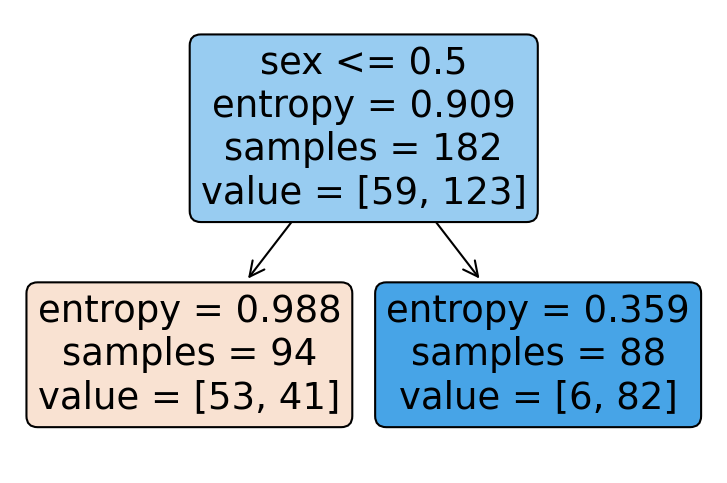

In [10]:
dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=1)
dtc.fit(X, y)

plt.figure(dpi=150)
tree.plot_tree(dtc, filled=True, rounded=True, feature_names=X.columns)
pass

Great, let's continue recursively splitting leafs.

In [11]:
X_sex0, y_sex0 = X[X.sex == 0], y[X.sex == 0]
X_sex1, y_sex1 = X[X.sex == 1], y[X.sex == 1]

In [12]:
info_gain(X_sex0, y_sex0, "pclass"), info_gain(X_sex0, y_sex0, "sibsp")

(0.010662134317034111, 0.026382458996248248)

In [13]:
info_gain(X_sex1, y_sex1, "pclass"), info_gain(X_sex1, y_sex1, "sibsp")

(0.046639193207634266, 0.009267018270491867)

We choose `sbisp` to split one leaf and `pclass` to split the other. But these features are not binary, i.e. they have more than two values. We could either add multiple new nodes one for each feature value or make a split in form of values $\leq$ threshold and values $>$ threshold. The latter is what scikit-learn's implementation is doing, so we need to find the split thresholds. Basically, we need to check every possible split between minimal and maximal feature value and check its information gain.

In [14]:
sibsp_values = sorted(X_sex0.sibsp.unique())
pclass_values = sorted(X_sex1.pclass.unique())

In [15]:
print("sibsp")
for i in range(len(sibsp_values) - 1):
    threshold = (sibsp_values[i] + sibsp_values[i + 1]) / 2
    y_leq = y_sex0[X_sex0.sibsp <= threshold]
    y_ge = y_sex0[X_sex0.sibsp > threshold]
    gain = entropy(y_sex0) - (
        len(y_leq) / len(y_sex0) * entropy(y_leq)
        + len(y_ge) / len(y_sex0) * entropy(y_ge)
    )
    print(f"threshold: {threshold}, info gain: {gain}")

print("pclass")
for i in range(len(pclass_values) - 1):
    threshold = (pclass_values[i] + pclass_values[i + 1]) / 2
    y_leq = y_sex1[X_sex1.pclass <= threshold]
    y_ge = y_sex1[X_sex1.pclass > threshold]
    gain = entropy(y_sex1) - (
        len(y_leq) / len(y_sex1) * entropy(y_leq)
        + len(y_ge) / len(y_sex1) * entropy(y_ge)
    )
    print(f"threshold: {threshold}, info gain: {gain}")

sibsp
threshold: 0.5, info gain: 0.014416095542854612
threshold: 1.5, info gain: 0.001048428215988051
threshold: 2.5, info gain: 0.008858126341896089
pclass
threshold: 1.5, info gain: 0.034022652112423335
threshold: 2.5, info gain: 0.04109768623858395


So we split on `sibsp` at $0.5$ and on `pclass` on $2.5$. Let's check with scikit-learn's implementation.

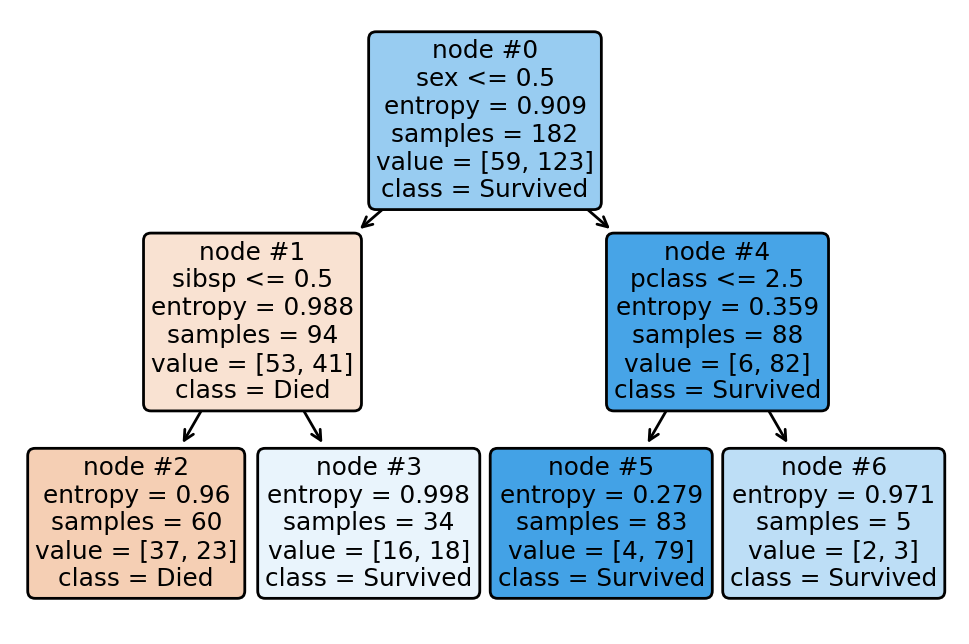

In [16]:
dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=2)
dtc.fit(X, y)

plt.figure(dpi=200)
tree.plot_tree(
    dtc,
    filled=True,
    rounded=True,
    node_ids=True,
    feature_names=X.columns,
    class_names=("Died", "Survived"),
)
pass

## Classifying new data
Let's say we have following new data to classify.

In [17]:
new_X = pd.DataFrame(
    {
        "sex": [0, 1, 1],
        "pclass": [1, 2, 3],
        "sibsp": [0, 1, 3],
    }
)
new_X

sex  pclass  sibsp
0    0       1      0
1    1       2      1
2    1       3      3

Who will these examples be classified?

In [18]:
dtc.predict(new_X)

array([0, 1, 1])

In [19]:
dtc.decision_path(new_X).toarray()

array([[1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 0, 1]])

## Final notes

### Impurity measure
By default, the label impurity measure in scikit-learn's implementation is Gini index and not entropy. They are fairly similar and Gini is defined as

$$ H(X) = \sum_{k} p_{k}(1-p_{k}) $$

where, again, $X$ is the data and $p_k$ is relative proportion of label $k$. The main advantage of Gini over entropy is not being biased towards features with many distinct values.

### Pruning
The presented tree building schema is pretty much ID3 algorithm. It is known to over-fit the data a lot. Most library implementations of decision trees are either C4.5 or CART algorithms that are based on ID3 and add few additional ideas. One of them is pruning. Pruning results in some nodes not being split if they do not significantly increase precision (pre-pruning) and some node being collapsed back into one node if the prediction accuracy is not affected much (post-pruning).